### TensorFlow 2.0 선택
[런타임] -> [런타임 유형변경]에서 하드웨어 가속기를 꼭 GPU로 설정!

In [42]:
# from google.colab import drive
# drive.mount('/content/drive')

## Class Activation Map 실습

이번 실습에서는 ImageNet pretrained model에 대해서 class activation map을 구해봅니다 

In [5]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

print(tf.__version__)
print(keras.__version__)

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

2.3.0
2.4.0


In [6]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [7]:
img_size = 224

In [8]:
## pretrained mobilenet load
mobilenet = MobileNet(weights='imagenet', include_top=True,
                     input_shape=(img_size, img_size, 3))

In [9]:
mobilenet.trainable = False
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [10]:
## input image를 받아서, 마지막 feature map을 출력해주는 model 생성
target_fmap = mobilenet.get_layer(name='conv_pw_13_relu').output
model = keras.models.Model(mobilenet.input, target_fmap)

In [11]:
## fully connected layer의 weight
weights = mobilenet.get_layer(name='conv_preds').get_weights()[0]
print(weights.shape)

(1, 1, 1024, 1000)


In [12]:
## weight reshape
weights = np.reshape(weights, (1024, 1000))
print(weights.shape)

(1024, 1000)


In [44]:
## test image를 읽어와서 224, 224로 resize
from PIL import Image

cur_dir = os.getcwd()
img_path = os.path.join(cur_dir, '', 'bird.jpg')
currimg = Image.open(img_path)
currimg = currimg.resize((img_size, img_size))
image = np.asarray(currimg)
image = np.reshape(image, (-1, img_size, img_size, 3))
print(image.shape)

(1, 224, 224, 3)


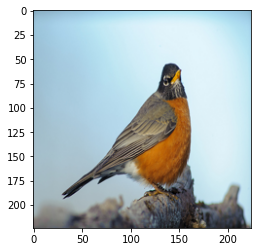

In [45]:
## 화면에 출력
plt.imshow(image[0])
plt.show()

In [46]:
## test image를 pretrained model에 넣고 feature map을 뽑음
fmap = model(preprocess_input(image))
fmap = np.reshape(np.array(fmap), (7,7,1024))
#fmap = np.reshape(np.array(fmap), (28,28,64))
print(fmap.shape)

(7, 7, 1024)


In [47]:
## test image에 대한 top-1 class 확인
prediction = mobilenet.predict(preprocess_input(image))

pred_class = np.argmax(prediction, -1)
pred_class

array([15], dtype=int64)

In [48]:
## top-1 외에 다른 class에 대한 label에 대해서도 CAM을 수행할 수 있도록 label list 생성
label_list = np.argsort(prediction, -1)
label_list = label_list[0, ::-1]
label_list[0]

15

In [49]:
label_list[2]

13

In [50]:
## top-5 확인
decode_predictions(prediction, top=5)

[[('n01558993', 'robin', 0.999723),
  ('n01532829', 'house_finch', 0.00016556578),
  ('n01534433', 'junco', 4.440222e-05),
  ('n01560419', 'bulbul', 1.8233135e-05),
  ('n01530575', 'brambling', 1.0919009e-05)]]

In [51]:
## top-5 class중 원하는 class에 대한 weight 가져오기
## 예) top-1 class: label_list[0], top-2 class: label_list[1], ...
#weights_cam = weights[:, pred_class[0]]
weights_cam = weights[:, label_list[0]]
weights_cam.shape

(1024,)

In [52]:
fmap.shape

(7, 7, 1024)

In [53]:
## CAM 만들기 (0으로 초기화한 후 weight x feature map을 누적해서 더함)
camsum = np.zeros((7,7))
for i in range(1024):
    camsum = camsum + weights_cam[i]*fmap[:,:,i]
camsum = camsum / 1024

In [54]:
# ## CAM 만들기 (0으로 초기화한 후 weight x feature map을 누적해서 더함)
# camsum = np.zeros((28,28))
# for i in range(64):
#     camsum = camsum + weights_cam[i]*fmap[:,:,i]
# camsum = camsum / 64

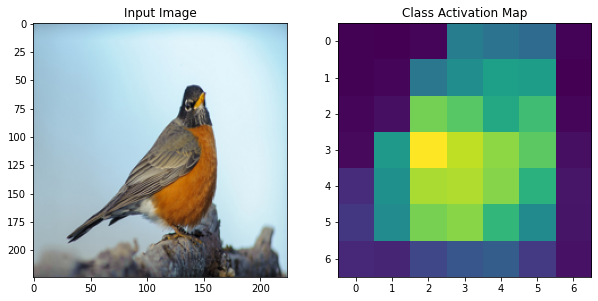

In [55]:
## 원본 image와 CAM 확인
fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(1,2,1)
ax1.imshow(image[0])
ax1.set_title("Input Image")
ax2 = fig1.add_subplot(1,2,2)
ax2.imshow(camsum)
ax2.set_title("Class Activation Map")
plt.show()

In [56]:
import matplotlib.cm as cm
from IPython.display import Image

In [57]:
# IMAGE_PATH = './CAM/data/rabbit.jpg'
# img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
# img = tf.keras.preprocessing.image.img_to_array(img)

In [58]:
heatmap = camsum
img=image[0]

In [61]:
# # We load the original image
# img = keras.preprocessing.image.load_img(image[0])
# img = keras.preprocessing.image.img_to_array(img)


# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.5+img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


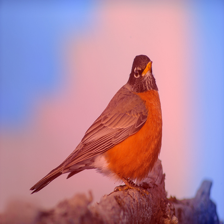

In [62]:
superimposed_img